In [1]:
import geopandas
import random
from shapely.geometry import Point
import rasterio
import matplotlib.pyplot as plt
import fiona.transform
from zipfile import ZipFile, ZIP_DEFLATED, ZIP_LZMA
import numpy as np
import io
import pandas as pd
import sqlite3

In [2]:
us = geopandas.read_file("zip://states.zip")
wi = us[us["STUSPS"] == "WI"]
s = wi.iloc[0,-1]

# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, polygon):
    points = {}
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < number:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            points["samp%d"%len(points)] = pnt
    return points

samp = generate_random(100, s)
city = {"madison":Point(-89.39,43.08),
        "milwaukee":Point(-87.97,43.06),
        "greenbay":Point(-87.99,44.52),
        "kenosha":Point(-87.87,42.59),
        "racine":Point(-87.81,42.73),
        "appleton":Point(-88.39,44.28),
        "waukesha":Point(-88.25,43.01),
        "oshkosh":Point(-88.56,44.02),
        "eauclaire":Point(-91.49,44.82),
        "janesville":Point(-89.01,42.69),
       }

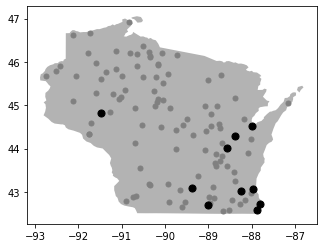

In [3]:
ax = wi.plot(color="0.7")
geopandas.GeoSeries(samp).plot(ax=ax, color="0.5", markersize=25)
geopandas.GeoSeries(city).plot(ax=ax, color="black", markersize=50)

In [4]:
# data: https://www.mrlc.gov/data/nlcd-land-cover-conus-all-years

import time

def get_map(raster, pt, radius):
    # lat/lon to raster coords
    x,y = fiona.transform.transform('EPSG:4326', raster.crs.to_proj4(), xs=[pt.x], ys=[pt.y])
    # raster coords to cell
    x,y = raster.index(x,y)
    x = x[0]
    y = y[0]
    return raster.read(window=((x-radius,x+radius),(y-radius,y+radius)))
    a.min(), a.max()

def extract_points(points, zf):
    rows = []

    for year in [2001, 2004, 2006, 2008, 2011, 2013, 2016]:
        print("YEAR", year)
        zipfile = "NLCD_Land_Cover_L48_20190424_full_zip.zip"
        path = f"zip://{zipfile}!NLCD_{year}_Land_Cover_L48_20190424.img"
        with rasterio.open(path) as f:
            for name, pt in points.items():
                if name.startswith("samp") and year != 2016:
                    continue
                radius = 250 if name.startswith("samp") else 600
                m = get_map(f, pt, radius=radius)
                fname = f"area{len(rows)}.npy"
                with zf.open(fname, "w") as img_file:
                    np.save(img_file, m[0,:,:])
                rows.append({"name":name, "year":year, "image":fname})
    return rows

points = {}
points.update(samp)
points.update(city)

t0 = time.time()
with ZipFile("images.zip", "w", compression=ZIP_LZMA) as zf:
    rows = extract_points(points, zf)
t1 = time.time()
print("SEC", t1-t0)

YEAR 2001
YEAR 2004
YEAR 2006
YEAR 2008
YEAR 2011
YEAR 2013
YEAR 2016
SEC 453.44148802757263


In [5]:
from matplotlib.colors import ListedColormap
use_cmap = np.zeros(shape=(256,4))
use_cmap[:,-1] = 1
uses = np.array([
    [0, 0.00000000000, 0.00000000000, 0.00000000000],
    [11, 0.27843137255, 0.41960784314, 0.62745098039],
    [12, 0.81960784314, 0.86666666667, 0.97647058824],
    [21, 0.86666666667, 0.78823529412, 0.78823529412],
    [22, 0.84705882353, 0.57647058824, 0.50980392157],
    [23, 0.92941176471, 0.00000000000, 0.00000000000],
    [24, 0.66666666667, 0.00000000000, 0.00000000000],
    [31, 0.69803921569, 0.67843137255, 0.63921568628],
    [41, 0.40784313726, 0.66666666667, 0.38823529412],
    [42, 0.10980392157, 0.38823529412, 0.18823529412],
    [43, 0.70980392157, 0.78823529412, 0.55686274510],
    [51, 0.64705882353, 0.54901960784, 0.18823529412],
    [52, 0.80000000000, 0.72941176471, 0.48627450980],
    [71, 0.88627450980, 0.88627450980, 0.75686274510],
    [72, 0.78823529412, 0.78823529412, 0.46666666667],
    [73, 0.60000000000, 0.75686274510, 0.27843137255],
    [74, 0.46666666667, 0.67843137255, 0.57647058824],
    [81, 0.85882352941, 0.84705882353, 0.23921568628],
    [82, 0.66666666667, 0.43921568628, 0.15686274510],
    [90, 0.72941176471, 0.84705882353, 0.91764705882],
    [95, 0.43921568628, 0.63921568628, 0.72941176471],
])
for row in uses:
    use_cmap[int(row[0]),:-1] = row[1:]
use_cmap = ListedColormap(use_cmap)

In [6]:
with sqlite3.connect("images.db") as c:
    places = pd.DataFrame([{"place_id": i+100, "name":name, "lat":pt.y, "lon":pt.x}
                 for i,(name,pt) in enumerate(points.items())])
    places.to_sql("places", c, index=False, if_exists="replace")
    ids = dict(places.set_index("name")["place_id"])
    images = pd.DataFrame(rows)
    images["place_id"] = images["name"].apply(lambda x: ids[x])
    images.iloc[:,1:].to_sql("images", c, index=False, if_exists="replace")

In [7]:
c = sqlite3.connect("images.db")
pd.read_sql("SELECT * FROM sqlite_master", c)

,type,name,tbl_name,rootpage,sql
0,table,places,places,4,"CREATE TABLE ""places"" (\n""place_id"" INTEGER,\n..."
1,table,images,images,2,"CREATE TABLE ""images"" (\n""year"" INTEGER,\n ""i..."


In [8]:
pd.read_sql("SELECT * FROM places LIMIT 10", c)

,place_id,name,lat,lon
0,100,samp0,42.821935,-88.151540
1,101,samp1,45.170729,-88.397469
2,102,samp2,44.941672,-89.897391
3,103,samp3,43.101989,-88.899274
4,104,samp4,46.618371,-92.127578
5,105,samp5,44.411609,-89.056707
6,106,samp6,45.765610,-91.370564
7,107,samp7,46.263517,-91.126876
8,108,samp8,43.181023,-90.365681
9,109,samp9,44.576266,-88.748236


In [9]:
pd.read_sql("SELECT * FROM images LIMIT 10", c)

,year,image,place_id
0,2001,area0.npy,200
1,2001,area1.npy,201
2,2001,area2.npy,202
3,2001,area3.npy,203
4,2001,area4.npy,204
5,2001,area5.npy,205
6,2001,area6.npy,206
7,2001,area7.npy,207
8,2001,area8.npy,208
9,2001,area9.npy,209


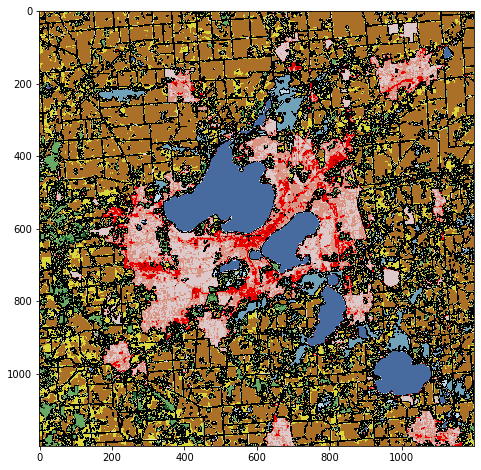

In [16]:
def show_img(name):
    plt.figure(figsize = (8,8))
    with ZipFile("images.zip") as zf:
        with zf.open(name) as f:
            buf = io.BytesIO(f.read())
            B = np.load(buf)
    plt.imshow(B, cmap=use_cmap, vmin=0, vmax=255)
    return B
A = show_img("area0.npy")